# AI Agent Epidemiological Model (Demo)

A notebook implementing the application of epidemiological modeling to AI-agentic systems security using Physics-Informed Neural Networks (PINNs).

## Model *(a bit inhanced)*

We model the spread of malicious behavior in multi-agent AI systems using a modified SEIR model:

- **S(t)**: Susceptible agents (healthy, vulnerable to attacks)
- **E(t)**: Exposed agents (attacked but not yet exhibiting malignant behavior) 
- **I(t)**: Infected agents (exhibiting malignant behavior, spreading attacks)
- **R(t)**: Removed agents (isolated/patched/immunized)

The system is governed by a system of ODEs:

$$\frac{dS}{dt} = -\lambda S - \nu S + \mu N$$
$$\frac{dE}{dt} = \lambda S - (\sigma + \mu + \nu) E$$  
$$\frac{dI}{dt} = \sigma E - (\gamma + \mu) I$$
$$\frac{dR}{dt} = \gamma I + \nu (S + E) - \mu R$$

$\lambda = \beta I/N + \alpha$ is the force of infection (a bit more sophisticated than in the slides)

- $\beta$ Attack transmission rate, depends on attack sucees rate (ASR)
- $\sigma$ Rate from exposed to infected (1/incubation_time)
- $\gamma$ 1/detection_time
- $\mu$ Agent turnover rate
- $\nu$ Immunization/patching rate
- $\alpha$ External attack pressure
- $N$ Total agent population

The basic reproduction number $R_{0} = \beta/(\gamma+\mu)$ is outbreak potential

- $R_{0} > 1$: Epidemic spreads through the agent population

- $R_{0} < 1$: Attack dies out

In [ ]:
import sys
import os
sys.path.append('../..')

import numpy as np
import torch
import matplotlib.pyplot as plt
from ai_epidemiology_model import AIEpidemiologyModel, SEIRPINNSolver
from bifurcation_analysis import BifurcationAnalyzer

# configuration 
def get_device():
    """best available device for mac or windows"""
    if torch.cuda.is_available():
        return 'cuda'
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

device = get_device()
print(f"Using device: {device}")

# random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Basic Model Setup and Solution

In [ ]:
# model parameters
params = {
    'beta': 0.3,    # attack transmission rate (ASR-dependent)
    'sigma': 0.1,   # rate from exposed to infected (1/incubation_time)
    'gamma': 0.05,  # 1e (1/detection_time)
    'mu': 0.01,     # agent turnover rate
    'nu': 0.02,     # immunization/patching rate
    'alpha': 0.001, # external attack pressure
    'N': 1000       # agent population, number of agents
}

# model instance
model = AIEpidemiologyModel(**params)
print(f"Basic Reproduction Number R_0 = {model.R0:.3f}")
print(f"Epidemic threshold {'EXCEEDED' if model.R0 > 1 else 'not exceeded'}")

Basic Reproduction Number R₀ = 5.000
Epidemic threshold EXCEEDED


In [5]:
# solve using PINNs (about 8 mins on M3)
solver = SEIRPINNSolver(model, device=device, network_type='ode_pinn')

# initial conditions: 1 infected agent, rest susceptible
initial_conditions = [999, 0, 1, 0]  # [S0, E0, I0, R0]
t_domain = [0, 200]  # time

print("Training PINN...")
# epochs and points
net, loss_history = solver.solve(t_domain, initial_conditions, num_epochs=300, num_points=500)

Network parameters: 74756
Training PINN...
Training PINN for SEIR model...


100%|██████████| 300/300 [08:42<00:00,  1.74s/it]


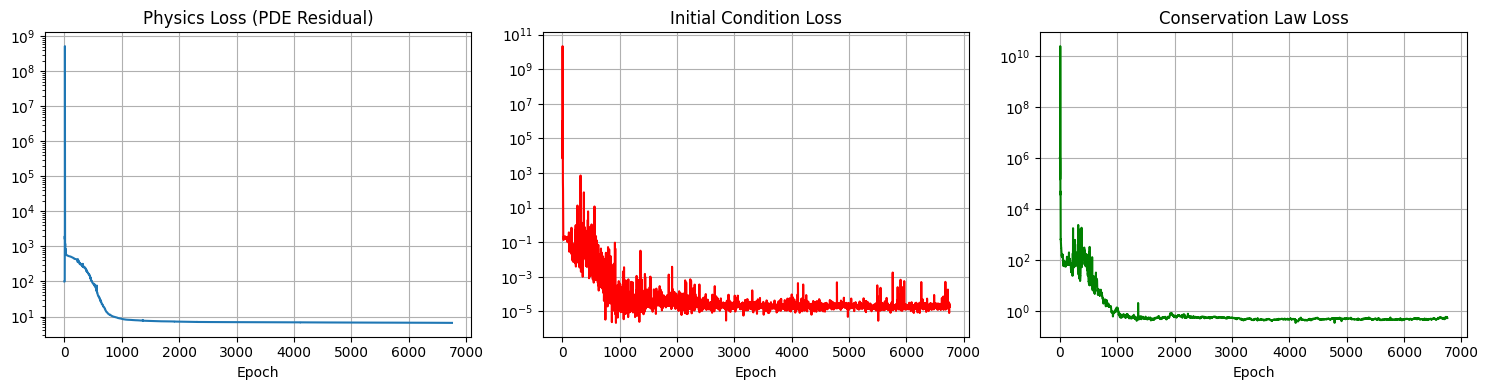

In [6]:
# plot training loss
loss_array = np.array(loss_history)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].semilogy(loss_array[:, 0], label='Physics Loss')
axes[0].set_title('Physics Loss (PDE Residual)')
axes[0].set_xlabel('Epoch')
axes[0].grid(True)

axes[1].semilogy(loss_array[:, 1], label='IC Loss', color='red')
axes[1].set_title('Initial Condition Loss')
axes[1].set_xlabel('Epoch')
axes[1].grid(True)

axes[2].semilogy(loss_array[:, 2], label='Conservation Loss', color='green')
axes[2].set_title('Conservation Law Loss')
axes[2].set_xlabel('Epoch')
axes[2].grid(True)

plt.tight_layout()
plt.show()

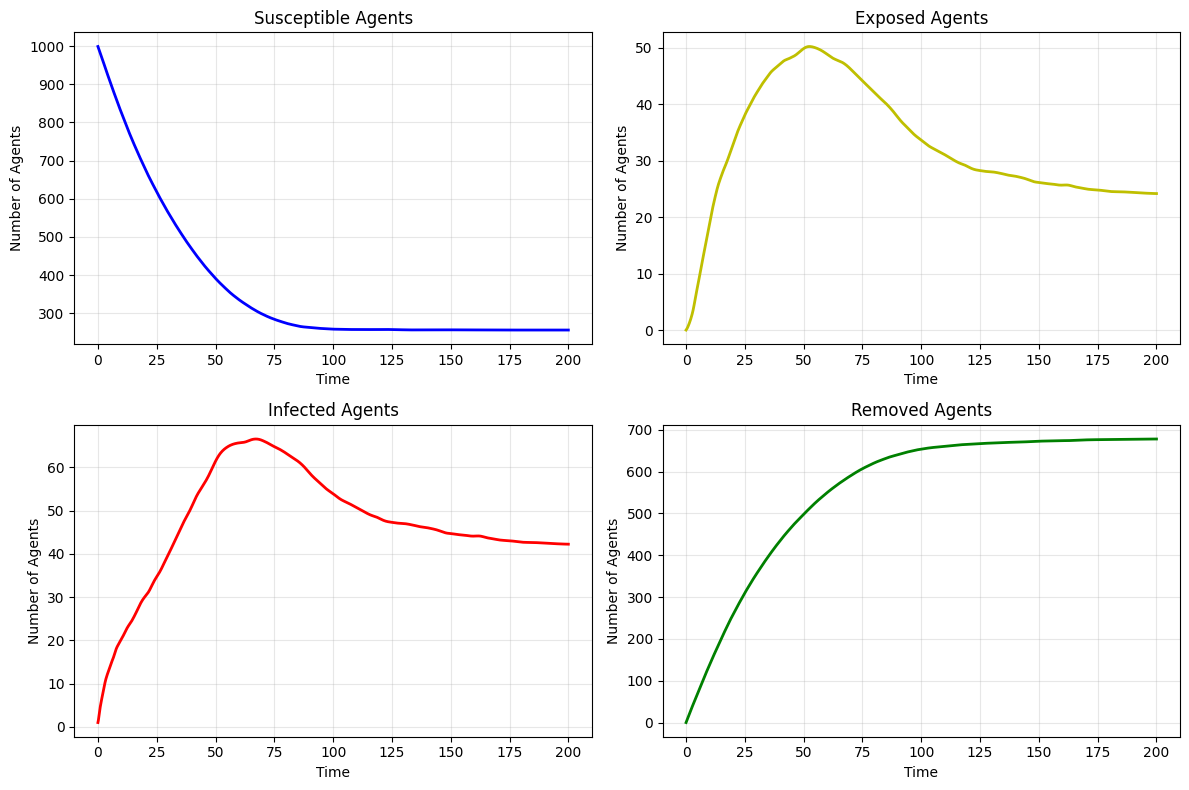

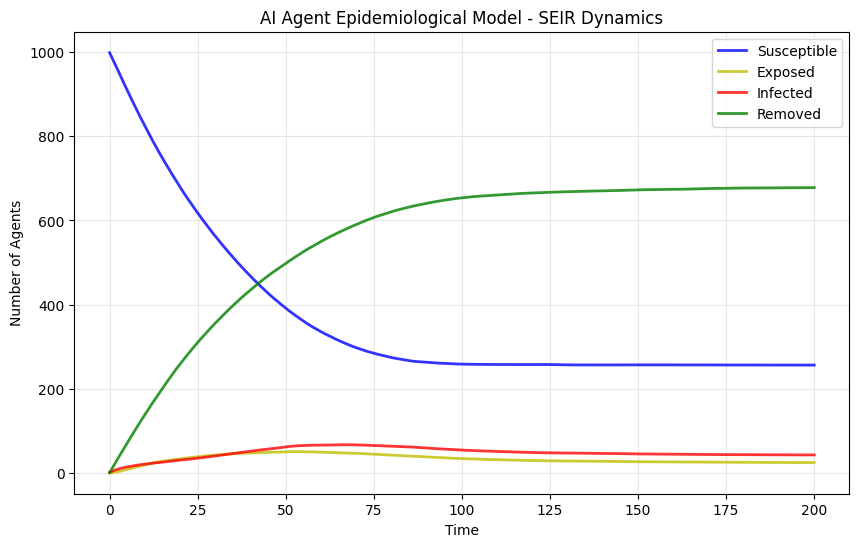


SUMMARY STATISTICS:
Peak infected agents: 66.6
Time to peak: 67.1
Final removed agents: 678.1
Attack size (final removed/total): 67.8%


In [7]:
# generate predictions
t_test = np.linspace(0, 200, 1000)
S_pred, E_pred, I_pred, R_pred = solver.predict(t_test)

# results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t_test, S_pred, 'b-', linewidth=2, label='Susceptible')
plt.xlabel('Time')
plt.ylabel('Number of Agents')
plt.title('Susceptible Agents')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(t_test, E_pred, 'y-', linewidth=2, label='Exposed')
plt.xlabel('Time')
plt.ylabel('Number of Agents')
plt.title('Exposed Agents')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(t_test, I_pred, 'r-', linewidth=2, label='Infected')
plt.xlabel('Time')
plt.ylabel('Number of Agents')
plt.title('Infected Agents')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(t_test, R_pred, 'g-', linewidth=2, label='Removed')
plt.xlabel('Time')
plt.ylabel('Number of Agents')
plt.title('Removed Agents')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# combined plot
plt.figure(figsize=(10, 6))
plt.plot(t_test, S_pred, 'b-', linewidth=2, label='Susceptible', alpha=0.8)
plt.plot(t_test, E_pred, 'y-', linewidth=2, label='Exposed', alpha=0.8)
plt.plot(t_test, I_pred, 'r-', linewidth=2, label='Infected', alpha=0.8)
plt.plot(t_test, R_pred, 'g-', linewidth=2, label='Removed', alpha=0.8)

plt.xlabel('Time')
plt.ylabel('Number of Agents')
plt.title('AI Agent Epidemiological Model - SEIR Dynamics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# summary
max_infected = np.max(I_pred)
time_to_peak = t_test[np.argmax(I_pred)]
final_removed = R_pred[-1]

print(f"\nSUMMARY STATISTICS:")
print(f"Peak infected agents: {max_infected:.1f}")
print(f"Time to peak: {time_to_peak:.1f}")
print(f"Final removed agents: {final_removed:.1f}")
print(f"Attack size (final removed/total): {final_removed/params['N']*100:.1f}%")

## 2. Scenario Analysis

Compare different attack scenarios and defense strategies.

Network parameters: 74756
Solving Baseline scenario (R₀ = 5.000)...
Training PINN for SEIR model...


100%|██████████| 200/200 [05:25<00:00,  1.63s/it]


Network parameters: 74756
Solving High ASR Attack scenario (R₀ = 13.333)...
Training PINN for SEIR model...


100%|██████████| 200/200 [05:26<00:00,  1.63s/it]


Network parameters: 74756
Solving Fast Spread scenario (R₀ = 5.000)...
Training PINN for SEIR model...


100%|██████████| 200/200 [05:39<00:00,  1.70s/it]


Network parameters: 74756
Solving Strong Defense scenario (R₀ = 1.429)...
Training PINN for SEIR model...


100%|██████████| 200/200 [02:43<00:00,  1.22it/s]


Network parameters: 74756
Solving Persistent Attack scenario (R₀ = 5.000)...
Training PINN for SEIR model...


100%|██████████| 200/200 [05:31<00:00,  1.66s/it]


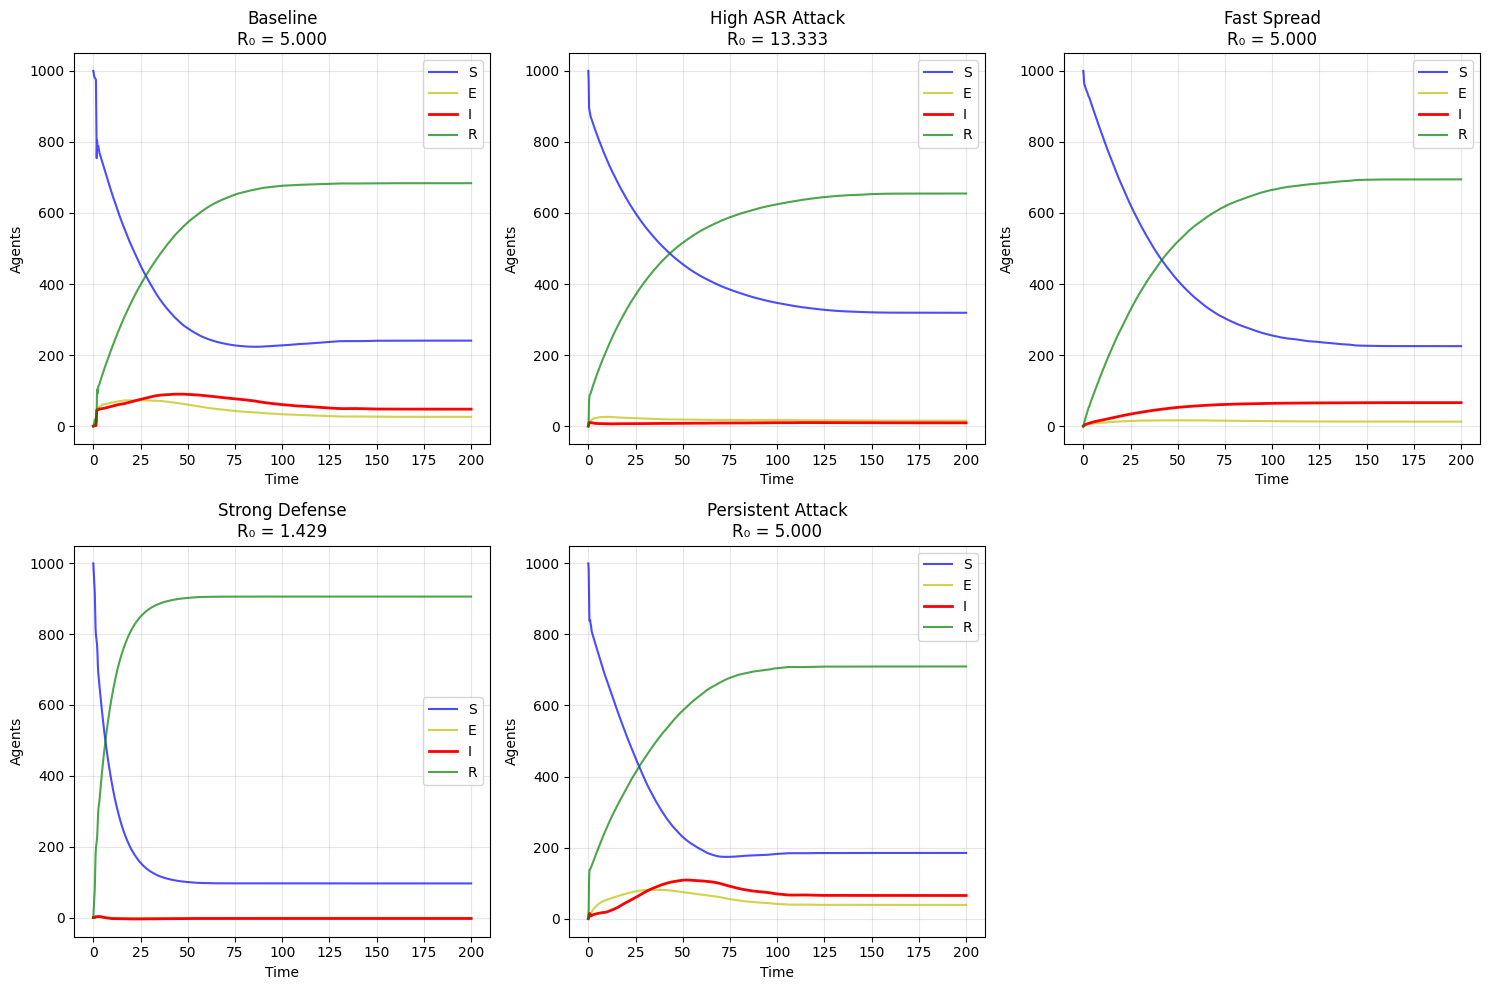

In [ ]:
# different scenarios (4-8 mins x 5 models = 20-40 mins)
scenarios = {
    'baseline': {'beta': 0.3, 'sigma': 0.1, 'gamma': 0.05, 'nu': 0.02, 'alpha': 0.001},
    'high ASR attack': {'beta': 0.8, 'sigma': 0.1, 'gamma': 0.05, 'nu': 0.02, 'alpha': 0.001},
    'fast spread': {'beta': 0.3, 'sigma': 0.3, 'gamma': 0.05, 'nu': 0.02, 'alpha': 0.001},
    'strong defense': {'beta': 0.3, 'sigma': 0.1, 'gamma': 0.2, 'nu': 0.1, 'alpha': 0.001},
    'persistent attack': {'beta': 0.3, 'sigma': 0.1, 'gamma': 0.05, 'nu': 0.02, 'alpha': 0.01},
}

scenario_results = {}
colors = ['blue', 'red', 'orange', 'green', 'purple']

plt.figure(figsize=(15, 10))

for i, (scenario_name, scenario_params) in enumerate(scenarios.items()):
    # base parameters
    full_params = params.copy()
    full_params.update(scenario_params)
    
    # model and solver
    scenario_model = AIEpidemiologyModel(**full_params)
    scenario_solver = SEIRPINNSolver(scenario_model, device=device, network_type='ode_pinn')
    
    print(f"Solving {scenario_name} scenario (R_0 = {scenario_model.R0:.3f})...")
    
    # solve with reduced complexity otherwise wait forever
    net, _ = scenario_solver.solve([0, 200], [999, 0, 1, 0], num_epochs=200, num_points=300)
    
    # predict
    S_pred, E_pred, I_pred, R_pred = scenario_solver.predict(t_test)
    
    scenario_results[scenario_name] = {
        'S': S_pred, 'E': E_pred, 'I': I_pred, 'R': R_pred,
        'R0': scenario_model.R0,
        'max_infected': np.max(I_pred),
        'final_removed': R_pred[-1]
    }
    
    # just infected agents
    plt.subplot(2, 3, i+1)
    plt.plot(t_test, S_pred, 'b-', alpha=0.7, label='S')
    plt.plot(t_test, E_pred, 'y-', alpha=0.7, label='E')
    plt.plot(t_test, I_pred, 'r-', linewidth=2, label='I')
    plt.plot(t_test, R_pred, 'g-', alpha=0.7, label='R')
    plt.title(f'{scenario_name}\nR₀ = {scenario_model.R0:.3f}')
    plt.xlabel('Time')
    plt.ylabel('Agents')
    plt.legend()
    plt.grid(True, alpha=0.3)

# del empty subplot if needed
if len(scenarios) < 6:
    plt.subplot(2, 3, 6)
    plt.axis('off')

plt.tight_layout()
plt.show()

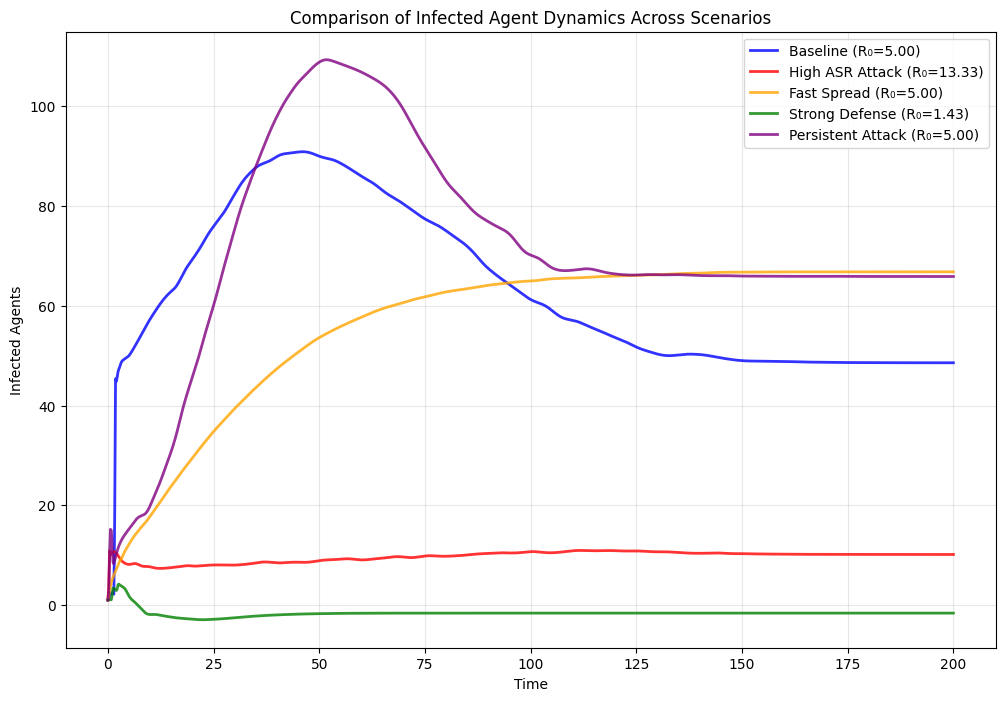


SCENARIO COMPARISON SUMMARY:
Scenario             R₀       Peak Infected   Final Removed   Attack Size %
Baseline             5.000    90.9            683.5           68.4        
High ASR Attack      13.333   10.9            654.5           65.5        
Fast Spread          5.000    66.8            694.2           69.4        
Strong Defense       1.429    4.2             905.5           90.6        
Persistent Attack    5.000    109.3           709.4           70.9        


In [ ]:
# comparissopn of infected curves
plt.figure(figsize=(12, 8))

for i, (scenario_name, results) in enumerate(scenario_results.items()):
    plt.plot(t_test, results['I'], linewidth=2, label=f"{scenario_name} (R₀={results['R0']:.2f})", 
             color=colors[i], alpha=0.8)

plt.xlabel('Time')
plt.ylabel('Infected Agents')
plt.title('Comparison of Infected Agent Dynamics Across Scenarios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# summary
print("\nSCENARIO COMPARISON SUMMARY:")
print("=" * 80)
print(f"{'Scenario':<20} {'R_0':<8} {'Peak Infected':<15} {'Final Removed':<15} {'Attack Size %':<12}")
print("=" * 80)

for scenario_name, results in scenario_results.items():
    attack_size = results['final_removed'] / params['N'] * 100
    print(f"{scenario_name:<20} {results['R0']:<8.3f} {results['max_infected']:<15.1f} "
          f"{results['final_removed']:<15.1f} {attack_size:<12.1f}")

## 3. Bifurcation Analysis

Analyze critical points and intervention strategies.

In [ ]:
# initialize bifurcation analyzer
analyzer = BifurcationAnalyzer(params)

# analyze stability of current system
stability = analyzer.stability_analysis(params)

print("STABILITY ANALYSIS")
print("=" * 50)

print(f"Basic Reproduction Number R_0 = {stability['R0']:.3f}")

for eq_name, info in stability.items():
    if eq_name == 'R0' or info is None:
        continue
        
    print(f"\n{eq_name.upper()} EQUILIBRIUM:")
    eq = info['equilibrium']
    print(f"  S = {eq['S']:.1f}, E = {eq['E']:.1f}, I = {eq['I']:.1f}, R = {eq['R']:.1f}")
    print(f"  Stable: {info['stable']}")
    print(f"  Dominant eigenvalue: {info['max_real_part']:.4f}")

STABILITY ANALYSIS
Basic Reproduction Number $R_0$ = 5.000

DISEASE_FREE EQUILIBRIUM:
  S = 322.6, E = 2.5, I = 0.0, R = 674.9
  Stable: False
  Dominant eigenvalue: 0.0078

ENDEMIC EQUILIBRIUM:
  S = 247.3, E = 38.9, I = 64.8, R = 649.0
  Stable: True
  Dominant eigenvalue: -0.0100


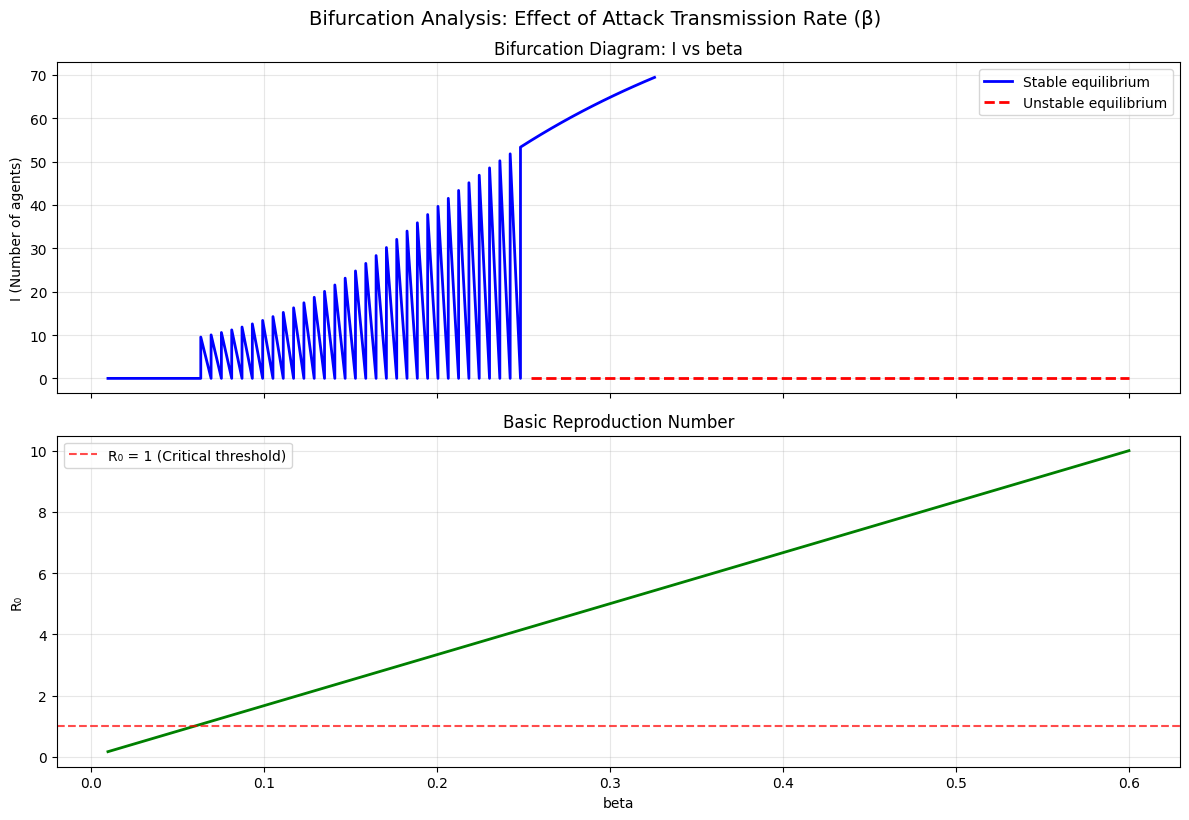

In [13]:
# bifurcation diagram for transmission rate (beta)
fig1 = analyzer.plot_bifurcation_diagram('beta', [0.01, 0.6], compartment='I', figsize=(12, 8))
plt.suptitle('Bifurcation Analysis: Effect of Attack Transmission Rate (β)', fontsize=14, y=1.02)
plt.show()

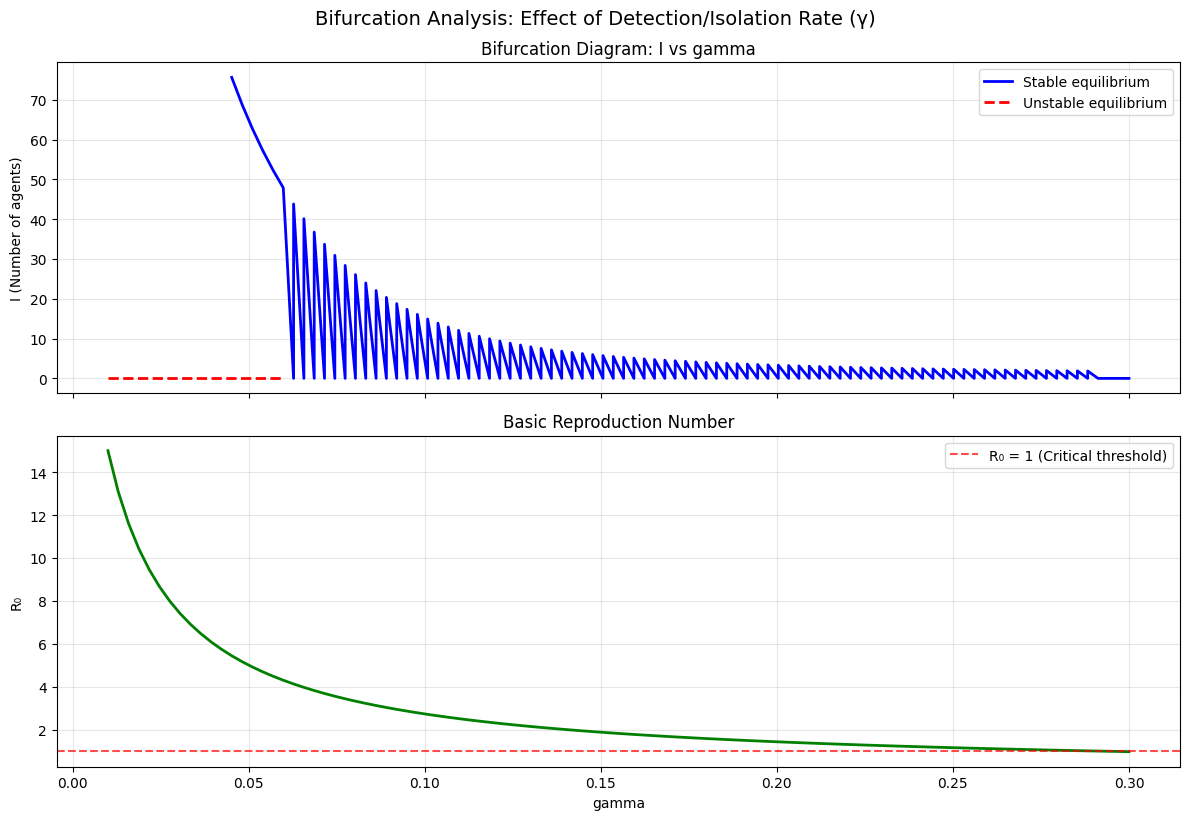

In [14]:
# bifurcation diagram for detection rate (gamma)
fig2 = analyzer.plot_bifurcation_diagram('gamma', [0.01, 0.3], compartment='I', figsize=(12, 8))
plt.suptitle('Bifurcation Analysis: Effect of Detection/Isolation Rate (γ)', fontsize=14, y=1.02)
plt.show()

In [15]:
# intervention analysis
print("\nINTERVENTION ANALYSIS")
print("=" * 50)

target_R0_values = [0.9, 0.8, 0.5]

for target_R0 in target_R0_values:
    print(f"\nTarget R₀ = {target_R0}:")
    print("-" * 30)
    
    interventions = analyzer.intervention_analysis(target_R0=target_R0)
    
    for intervention_name, details in interventions.items():
        if 'message' in details:
            print(details['message'])
            continue
            
        print(f"\n  {intervention_name.replace('_', ' ').title()}:")
        
        if 'required_value' in details:
            change_pct = abs(1 - details['required_value']/details['current_value']) * 100
            direction = "reduce" if details['required_value'] < details['current_value'] else "increase"
            print(f"    {direction.title()} {details['parameter']} by {change_pct:.1f}%")
            print(f"    From {details['current_value']:.4f} to {details['required_value']:.4f}")
        
        print(f"    Strategy: {details['description']}")


INTERVENTION ANALYSIS

Target R₀ = 0.9:
------------------------------

  Reduce Transmission:
    Reduce beta by 82.0%
    From 0.3000 to 0.0540
    Strategy: Improve agent robustness, network segmentation

  Increase Detection:
    Increase gamma by 546.7%
    From 0.0500 to 0.3233
    Strategy: Improve monitoring, faster isolation

  Increase Immunization:
    Strategy: Proactive patching, security updates

Target R₀ = 0.8:
------------------------------

  Reduce Transmission:
    Reduce beta by 84.0%
    From 0.3000 to 0.0480
    Strategy: Improve agent robustness, network segmentation

  Increase Detection:
    Increase gamma by 630.0%
    From 0.0500 to 0.3650
    Strategy: Improve monitoring, faster isolation

  Increase Immunization:
    Strategy: Proactive patching, security updates

Target R₀ = 0.5:
------------------------------

  Reduce Transmission:
    Reduce beta by 90.0%
    From 0.3000 to 0.0300
    Strategy: Improve agent robustness, network segmentation

  Increas

## 4. Intervention Simulation

applying interventions during an ongoing attack.

In [16]:
def simulate_intervention(intervention_time=50, intervention_type='detection'):
    """Simulate applying intervention at specified time"""
    
    # Pre-intervention parameters (vulnerable system)
    pre_params = {
        'beta': 0.5,    # High attack success rate
        'sigma': 0.15,  # Fast progression  
        'gamma': 0.03,  # Slow detection
        'mu': 0.01,
        'nu': 0.01,     # Minimal proactive patching
        'alpha': 0.002,
        'N': 1000
    }
    
    # Post-intervention parameters
    post_params = pre_params.copy()
    
    if intervention_type == 'detection':
        post_params['gamma'] = 0.15  # 5x faster detection
        intervention_desc = "Enhanced monitoring & rapid isolation"
    elif intervention_type == 'immunization':
        post_params['nu'] = 0.1     # 10x faster patching
        intervention_desc = "Emergency patching campaign"
    elif intervention_type == 'segmentation':
        post_params['beta'] = 0.1   # Reduce transmission by 80%
        intervention_desc = "Network segmentation & isolation"
    elif intervention_type == 'combined':
        post_params['gamma'] = 0.12
        post_params['nu'] = 0.08
        post_params['beta'] = 0.2
        intervention_desc = "Combined defense strategy"
    
    # solve pre-intervention period
    pre_model = AIEpidemiologyModel(**pre_params)
    pre_solver = SEIRPINNSolver(pre_model, device=device, network_type='ode_pinn')
    
    print(f"Pre-intervention R₀ = {pre_model.R0:.3f}")
    
    # solve for first phase with reduced num of epochs
    _, _ = pre_solver.solve([0, intervention_time], [999, 0, 1, 0], num_epochs=150, num_points=200)
    
    # get state at intervention time
    t_intervention = np.array([intervention_time])
    S_int, E_int, I_int, R_int = pre_solver.predict(t_intervention)
    
    print(f"State at intervention (t={intervention_time}): S={S_int[0]:.0f}, E={E_int[0]:.0f}, I={I_int[0]:.0f}, R={R_int[0]:.0f}")
    
    # solve post-intervention period
    post_model = AIEpidemiologyModel(**post_params)
    post_solver = SEIRPINNSolver(post_model, device=device, network_type='ode_pinn')
    
    print(f"Post-intervention R₀ = {post_model.R0:.3f}")
    
    # continue from intervention state
    post_initial = [S_int[0], E_int[0], I_int[0], R_int[0]]
    _, _ = post_solver.solve([intervention_time, 200], post_initial, num_epochs=150, num_points=200)
    
    # generate full timeline predictions
    t_pre = np.linspace(0, intervention_time, 200)
    t_post = np.linspace(intervention_time, 200, 300)
    
    S_pre, E_pre, I_pre, R_pre = pre_solver.predict(t_pre)
    S_post, E_post, I_post, R_post = post_solver.predict(t_post)
    
    # combine timelines
    t_full = np.concatenate([t_pre, t_post[1:]])  # avoid duplicate intervention time
    S_full = np.concatenate([S_pre, S_post[1:]])
    E_full = np.concatenate([E_pre, E_post[1:]])
    I_full = np.concatenate([I_pre, I_post[1:]])
    R_full = np.concatenate([R_pre, R_post[1:]])
    
    return {
        'time': t_full,
        'S': S_full, 'E': E_full, 'I': I_full, 'R': R_full,
        'intervention_time': intervention_time,
        'intervention_desc': intervention_desc,
        'pre_R0': pre_model.R0,
        'post_R0': post_model.R0
    }

# different interventions with reduced scope for demo
interventions = ['detection', 'segmentation', 'combined']
intervention_results = {}

for intervention in interventions:
    print(f"\nSimulating {intervention} intervention...")
    result = simulate_intervention(intervention_time=50, intervention_type=intervention)
    intervention_results[intervention] = result


Simulating detection intervention...
Network parameters: 74756
Pre-intervention R₀ = 12.500
Training PINN for SEIR model...


100%|██████████| 150/150 [02:34<00:00,  1.03s/it]


State at intervention (t=50): S=718, E=18, I=10, R=262
Network parameters: 74756
Post-intervention R₀ = 3.125
Training PINN for SEIR model...


100%|██████████| 150/150 [00:34<00:00,  4.40it/s]



Simulating segmentation intervention...
Network parameters: 74756
Pre-intervention R₀ = 12.500
Training PINN for SEIR model...


100%|██████████| 150/150 [02:11<00:00,  1.14it/s]


State at intervention (t=50): S=724, E=16, I=8, R=260
Network parameters: 74756
Post-intervention R₀ = 2.500
Training PINN for SEIR model...


100%|██████████| 150/150 [02:11<00:00,  1.14it/s]



Simulating combined intervention...
Network parameters: 74756
Pre-intervention R₀ = 12.500
Training PINN for SEIR model...


100%|██████████| 150/150 [03:18<00:00,  1.33s/it]


State at intervention (t=50): S=722, E=16, I=9, R=261
Network parameters: 74756
Post-intervention R₀ = 1.538
Training PINN for SEIR model...


100%|██████████| 150/150 [01:24<00:00,  1.77it/s]


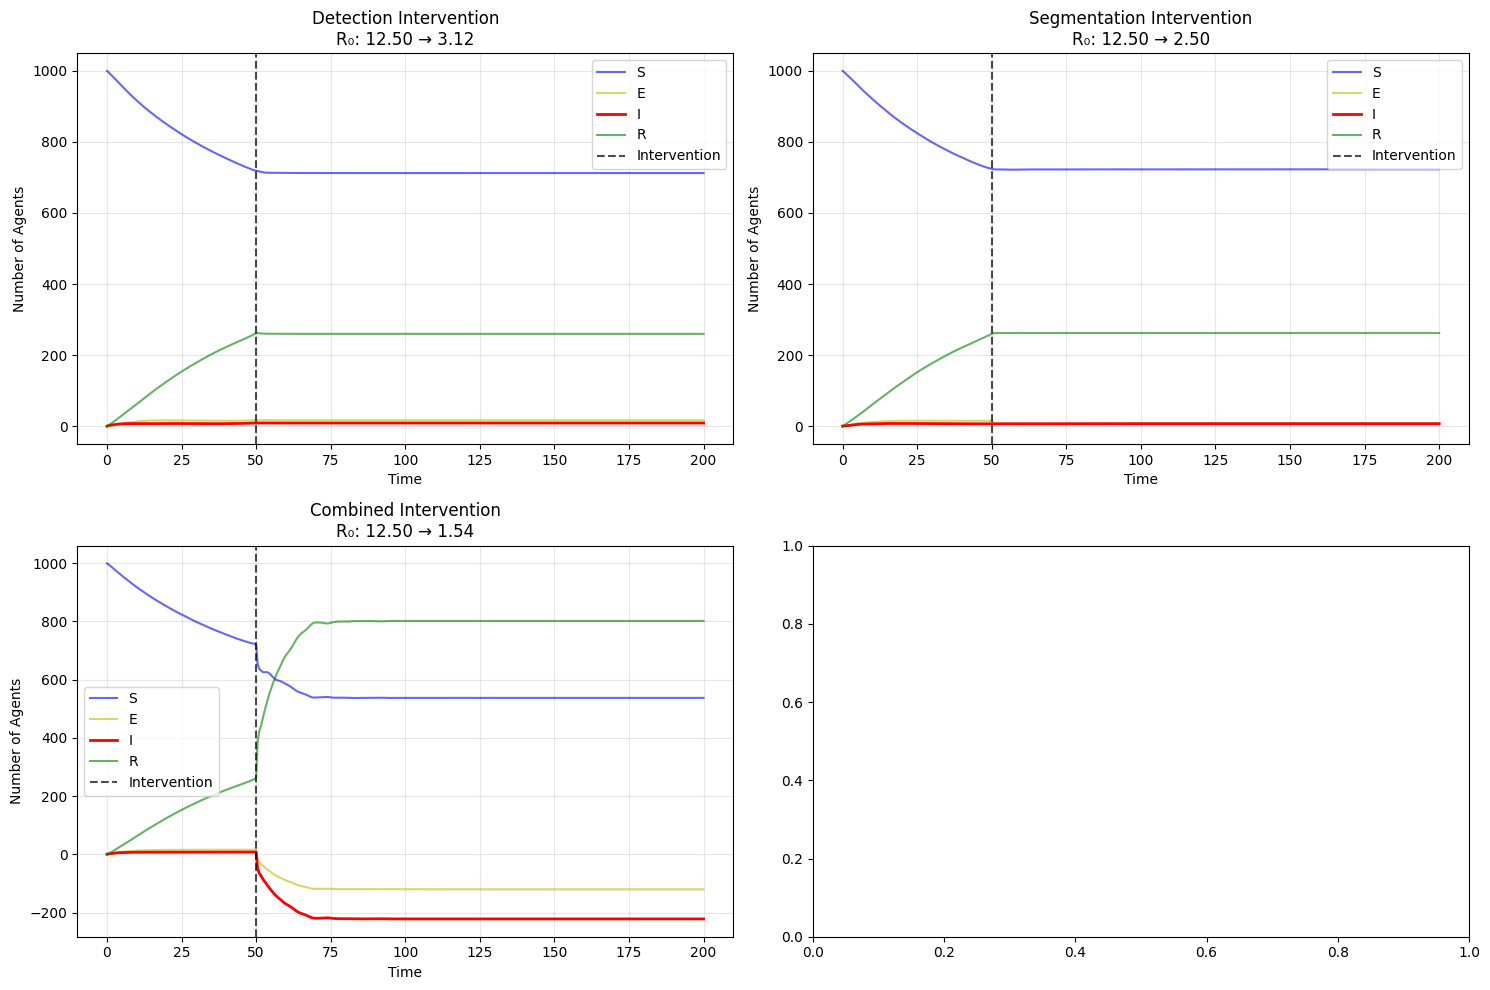

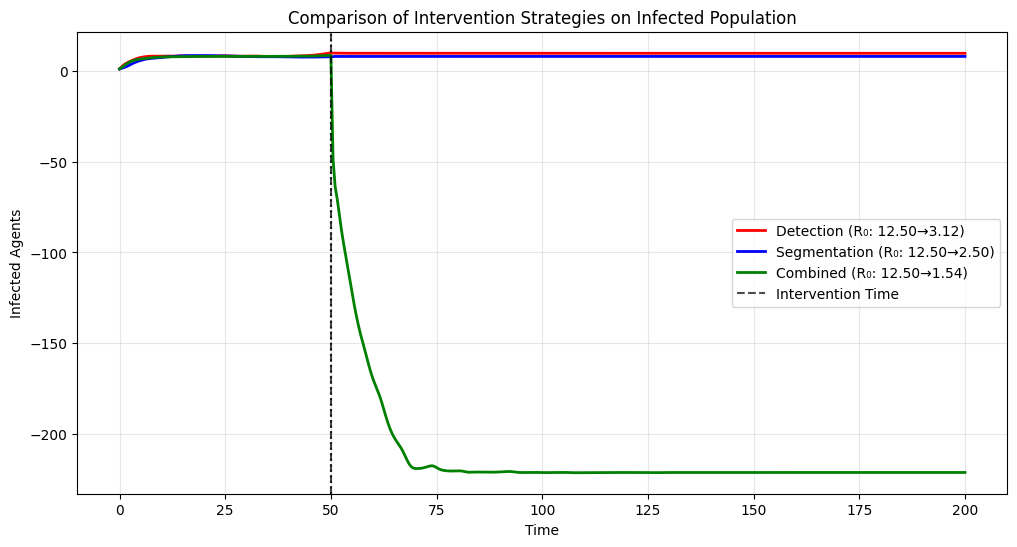


INTERVENTION EFFECTIVENESS SUMMARY:
Intervention    Peak I     Time to Peak    Final R    R₀ Change   
Detection       10         50.0            260        -9.38       
Segmentation    8          19.6            263        -10.00      
Combined        9          50.0            801        -10.96      


In [17]:
# plot intervention comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

colors = ['red', 'blue', 'green', 'purple']

for i, (intervention, result) in enumerate(intervention_results.items()):
    ax = axes[i]
    
    # all compartments
    ax.plot(result['time'], result['S'], 'b-', alpha=0.6, label='S')
    ax.plot(result['time'], result['E'], 'y-', alpha=0.6, label='E')
    ax.plot(result['time'], result['I'], 'r-', linewidth=2, label='I')
    ax.plot(result['time'], result['R'], 'g-', alpha=0.6, label='R')
    
    # intervention time
    ax.axvline(x=result['intervention_time'], color='black', linestyle='--', alpha=0.7, label='Intervention')
    
    ax.set_title(f"{intervention.title()} Intervention\nR₀: {result['pre_R0']:.2f} → {result['post_R0']:.2f}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Agents')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# compare infected curves only
plt.figure(figsize=(12, 6))

for i, (intervention, result) in enumerate(intervention_results.items()):
    plt.plot(result['time'], result['I'], linewidth=2, color=colors[i], 
             label=f"{intervention.title()} (R₀: {result['pre_R0']:.2f}→{result['post_R0']:.2f})")
    
    # intervention time
    plt.axvline(x=result['intervention_time'], color=colors[i], linestyle=':', alpha=0.5)

plt.axvline(x=50, color='black', linestyle='--', alpha=0.7, label='Intervention Time')
plt.xlabel('Time')
plt.ylabel('Infected Agents')
plt.title('Comparison of Intervention Strategies on Infected Population')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# summary
print("\nINTERVENTION EFFECTIVENESS SUMMARY:")
print("=" * 70)
print(f"{'Intervention':<15} {'Peak I':<10} {'Time to Peak':<15} {'Final R':<10} {'R₀ Change':<12}")
print("=" * 70)

for intervention, result in intervention_results.items():
    peak_infected = np.max(result['I'])
    time_to_peak = result['time'][np.argmax(result['I'])]
    final_removed = result['R'][-1]
    r0_change = result['post_R0'] - result['pre_R0']
    
    print(f"{intervention.title():<15} {peak_infected:<10.0f} {time_to_peak:<15.1f} "
          f"{final_removed:<10.0f} {r0_change:<12.2f}")